# Lesson 2: Federated Training Process

Welcome to Lesson 2!

To access the `requirements.txt` and `utils2.py` file for this course, go to `File` and click `Open`.

#### 1. Load imports

In [12]:
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import ndarrays_to_parameters, Context
from flwr.server import ServerApp, ServerConfig
from flwr.server import ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

from utils2 import *

#### 2. Set up the training and testing datasets

* Set up the MNIST training datasets.

In [13]:
trainset = datasets.MNIST(
    "./MNIST_data/", download=True, train=True, transform=transform
)

total_length = len(trainset)
split_size = total_length // 3
torch.manual_seed(42)
part1, part2, part3 = random_split(trainset, [split_size] * 3)

part1 = exclude_digits(part1, excluded_digits=[1, 3, 7])
part2 = exclude_digits(part2, excluded_digits=[2, 5, 8])
part3 = exclude_digits(part3, excluded_digits=[4, 6, 9])

train_sets = [part1, part2, part3]

> Note: The function ```exclude_digits``` has been provided for your use. You can find it in the `utils2.py` file. 

  To access this file, go to `File` and click `Open`.

* Set up the MNIST testing datasets.

In [14]:
testset = datasets.MNIST(
    "./MNIST_data/", download=True, train=False, transform=transform
)
print("Number of examples in `testset`:", len(testset))

testset_137 = include_digits(testset, [1, 3, 7])
testset_258 = include_digits(testset, [2, 5, 8])
testset_469 = include_digits(testset, [4, 6, 9])

Number of examples in `testset`: 10000


> Note: The function ```include_digits``` has been provided for your use. You can find it in the `utils2.py` file. 

  To access this file, go to `File` and click `Open`.

#### 3. Define training and testing in the pipeline

* Set functions for the client-server exchange of the training information.

In [15]:
# Sets the parameters of the model
def set_weights(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict(
        {k: torch.tensor(v) for k, v in params_dict}
    )
    net.load_state_dict(state_dict, strict=True)

# Retrieves the parameters from the model
def get_weights(net):
    ndarrays = [
        val.cpu().numpy() for _, val in net.state_dict().items()
    ]
    return ndarrays

* Connect the training in the pipeline using the Flower Client.

In [16]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainset, testset):
        self.net = net
        self.trainset = trainset
        self.testset = testset

    # Train the model
    def fit(self, parameters, config):
        set_weights(self.net, parameters)
        train_model(self.net, self.trainset)
        return get_weights(self.net), len(self.trainset), {}

    # Test the model
    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        set_weights(self.net, parameters)
        loss, accuracy = evaluate_model(self.net, self.testset)
        return loss, len(self.testset), {"accuracy": accuracy}

* Flower calls `client_fn` whenever it needs an instance of one particular client to call fit or evaluate.

In [17]:
# Client function
def client_fn(context: Context) -> Client:
    net = SimpleModel()
    partition_id = int(context.node_config["partition-id"])
    client_train = train_sets[int(partition_id)]
    client_test = testset
    return FlowerClient(net, client_train, client_test).to_client()

* Create an instance of the ClientApp.

In [18]:
client = ClientApp(client_fn)

* Define `evaluate` for testing.

The `evaluate` method evaluates the performance of the neural network model using the provided parameters and the test dataset (`testset`).

In [19]:
def evaluate(server_round, parameters, config):
    net = SimpleModel()
    set_weights(net, parameters)

    _, accuracy = evaluate_model(net, testset)
    _, accuracy137 = evaluate_model(net, testset_137)
    _, accuracy258 = evaluate_model(net, testset_258)
    _, accuracy469 = evaluate_model(net, testset_469)

    log(INFO, "test accuracy on all digits: %.4f", accuracy)
    log(INFO, "test accuracy on [1,3,7]: %.4f", accuracy137)
    log(INFO, "test accuracy on [2,5,8]: %.4f", accuracy258)
    log(INFO, "test accuracy on [4,6,9]: %.4f", accuracy469)

    if server_round == 3:
        cm = compute_confusion_matrix(net, testset)
        plot_confusion_matrix(cm, "Final Global Model")

* Strategy: Federated Average 'FedAvg'.

The federated averaging strategy (`strategy.FedAvg`) is created for federated learning.

In [20]:
net = SimpleModel()
params = ndarrays_to_parameters(get_weights(net))

def server_fn(context: Context):
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.0,
        initial_parameters=params,
        evaluate_fn=evaluate,
    )
    config=ServerConfig(num_rounds=3)
    return ServerAppComponents(
        strategy=strategy,
        config=config,
    )

* Create an instance of ServerApp.

In [21]:
server = ServerApp(server_fn=server_fn)

* Start training.

INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      test accuracy on all digits: 0.1267
INFO :      test accuracy on [1,3,7]: 0.2275
INFO :      test accuracy on [2,5,8]: 0.1201
INFO :      test accuracy on [4,6,9]: 0.0380
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      test accuracy on all digits: 0.8609
INFO :      test accuracy on [1,3,7]: 0.9483
INFO :      test accuracy on [2,5,8]: 0.7647
INFO :      test accuracy on [4,6,9]: 0.8159
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      tes

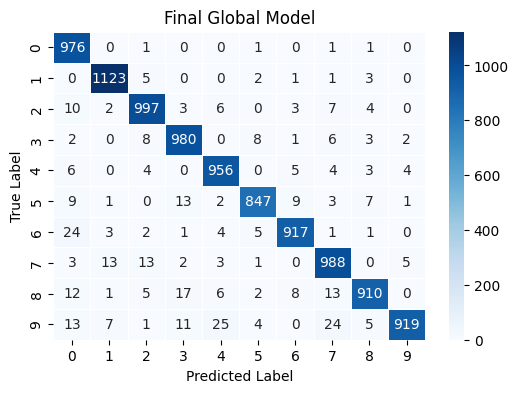

INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 50.85s
INFO :      


In [22]:
# Initiate the simulation passing the server and client apps
# Specify the number of super nodes that will be selected on every round
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=3,
    backend_config=backend_setup,
)